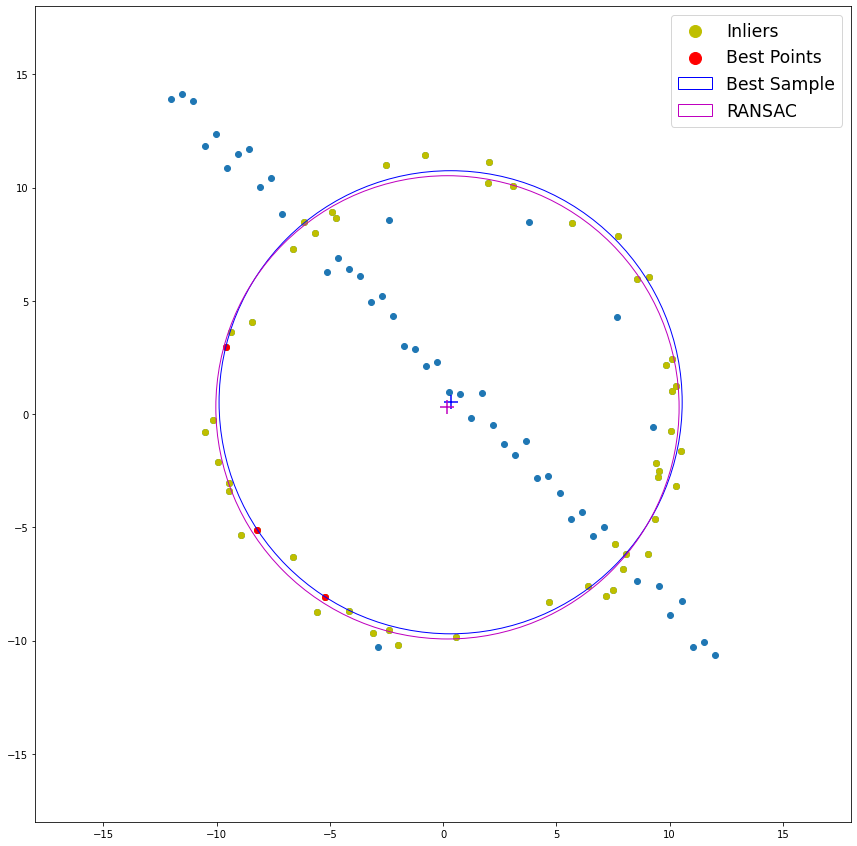

In [53]:
#Q1
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt
import random
#np.random.seed(0)

N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
X_circle_paramle_param = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1) , y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

# Estimate the cicle using RANSAC algorithm
def circleEstimate(min_iterations, min_inliers, no_of_points, points, inlier_treshold,current_inliers):
    iterations_left = min_inliers
    while (1):
        if (current_inliers > min_inliers and iterations_left < 0):
            break
        # Randomly choose 3 points
        sample = random.sample(range(1, no_of_points), 3)
        x1 = np.zeros([3,2])
        for i in range(3):
            x1[i]=points[sample[i]]
        
        # Calculate the coordinates of the center & the radius of the circle passing through those 3 points
        x2 = np.hstack((x1,np.ones((3,1))))
        x3 = (-1*((x1[:,0]*x1[:,0])+(x1[:,1]*x1[:,1]))).reshape(3,1)
        c = np.matmul(np.linalg.inv(x2),x3)
        c_x , c_y = -c[0]/2 , -c[1]/2
        radius = np.sqrt(c_x*c_x + c_y*c_y - c[2])

        if radius > 30:continue
        
        no_of_inliers, inlier_points = inlierCount(points, c_x, c_y, radius, inlier_treshold) # Find inliers
        
        # Check whether it is the best model with most inliers
        if current_inliers < no_of_inliers:
            current_inliers, circle_parameters, best_inlier_points, best_sample = no_of_inliers, [c_x,c_y,radius], inlier_points, x1
        if current_inliers >= min_inliers:
            iterations_left-=1
    
    return current_inliers, circle_parameters, best_inlier_points, best_sample

# Check whether a given point is an inlier or not
def isInlier(x, y, cx, cy, r, T):
    r_=(x-cx)**2+(y-cy)**2
    if r-T < np.sqrt(r_) < r+T:
        return True
    else: return False

# Find inliers of a given circle
def inlierCount(points, cx, cy, r, T):
    n=0
    inlier_arr=np.zeros((1,2))
    for i in points:
        if isInlier(i[0], i[1], cx, cy, r, T):
            n+=1
            if not inlier_arr.any():
                inlier_arr[0]=i
            else:
                inlier_arr=np.concatenate((inlier_arr,[i]),axis=0)
    return n,inlier_arr

# calculate the distance of each 2D points from the center (xc, yc)
def calc_R(xc, yc):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

# calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)
def f_2(c):
    Ri = calc_R(*c)
    return Ri - Ri.mean()

# least square method circle fit
def leastSquareCirc(x,y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2 = calc_R(*center_2)
    R_2 = Ri_2.mean()
    residu_2 = sum((Ri_2 - R_2)**2)
    return round(xc_2,5),round(yc_2,5),round(R_2,5),residu_2

m1, circle_param, inlier_points, bestpoints = circleEstimate(250,42,N,X,0.9,0)
x, y = inlier_points[:,0],inlier_points[:,1]

figure, axes = plt.subplots(figsize=(15,15))

# plot the circle estimated from the sample leading to the best estimate
draw_circle = plt.Circle((circle_param[0], circle_param[1]), circle_param[2],fill=False,color='b',label='Best Sample')
axes.scatter(X[:,0], X[:,1]) # Plot points
axes.scatter(circle_param[0], circle_param[1],color='b',marker='+',s=180) # Plot center of the best sample cicle
axes.scatter(x, y,color='y',label='Inliers') # Plot inliers
axes.scatter(bestpoints[:,0], bestpoints[:,1],color='r',label='Best Points') # Plot 3-points of the best sample
axes.set_aspect(1)
axes.add_artist(draw_circle)

a,b,c,d = leastSquareCirc(x,y) # Least square circle fit out of inliers

draw_circle = plt.Circle((a, b), c,fill=False,color='m',label='RANSAC') # Plot best fit circle
axes.add_artist(draw_circle)
axes.scatter(a, b,marker='+',c='m',s=180) # Plot center
plt.xlim(-18,18)
plt.ylim(-18,18)
plt.legend(fontsize='xx-large',markerscale=2.0)
plt.show()

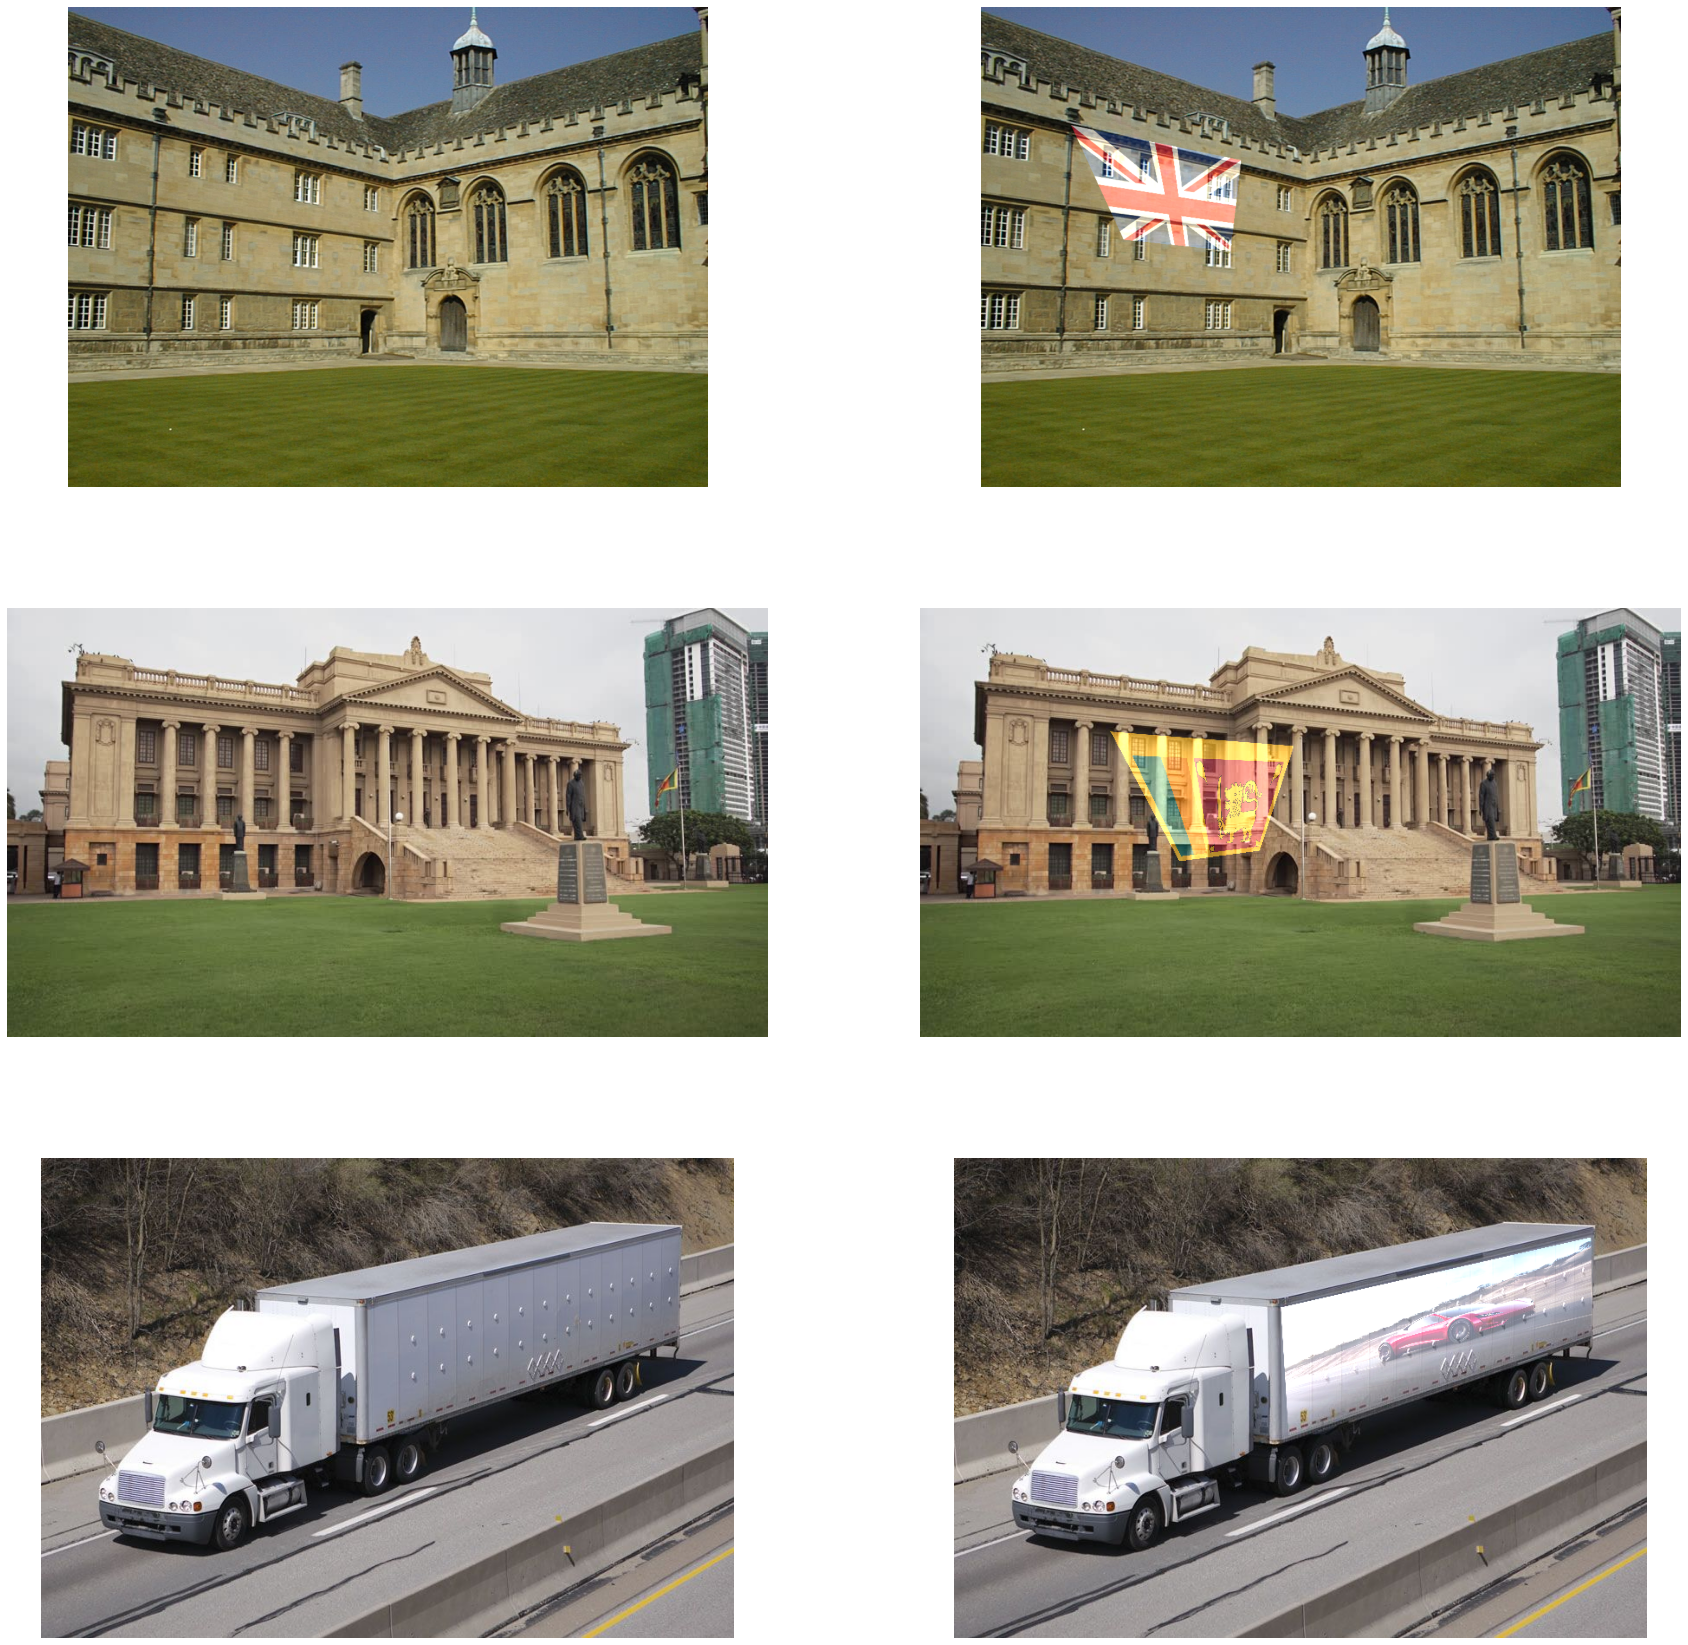

In [41]:
import cv2 as cv

point_matrix = np.zeros((4,2),dtype=np.float32)
 
counter = 0
# mouse-clicking
def mouseClicks(event,x,y,flags,params):
    global counter
    if event == cv.EVENT_LBUTTONDOWN:
        point_matrix[counter] = x,y
        counter = counter + 1
    if counter==4:
        cv.destroyAllWindows()
        counter=0

# getting points by mouse-clicking
def gettingPoints(im, win_name):
    cv.imshow(win_name,im)
    cv.setMouseCallback(win_name,mouseClicks)
    cv.waitKey(0)
    cv.destroyAllWindows()

def BGR2RGB(im):
    return cv.cvtColor(im,cv.COLOR_BGR2RGB)

fig , ax = plt.subplots(3 , 2 ,figsize=(30,30))

for j in range(1,4):
    img = cv.imread(r'im{}.jpg'.format(j))
    assert img is not None
    flag = cv.imread(r'f{}.png'.format(j))
    assert flag is not None

    gettingPoints(img, 'img{}'.format(j))

    # computing homography
    H = cv.getPerspectiveTransform(np.array([[0, 0],[np.shape(flag)[1],0],[0,np.shape(flag)[0]],[np.shape(flag)[1],np.shape(flag)[0]]],dtype=np.float32), point_matrix)
    
    # warping the flag
    warped_f = cv.warpPerspective(flag, H,(np.shape(img)[1],np.shape(img)[0]))
    
    # blending the warped flag on to the architectural image
    result = cv.addWeighted(img, 1, warped_f, 0.6, 0)

    ax[j-1,0].imshow(BGR2RGB(img))
    #ax[j-1,1].imshow(BGR2RGB(flag))
    ax[j-1,1].imshow(BGR2RGB(result))
    for k in range(2):
        ax[j-1,k].axis('off')
plt.show()

Sum of square difference between computed 1to5 homography & given one = 35645.71294848187

Compute Graffiti img 1to3 homography & Graffiti img 3to5 homography, then by using those two, we can compute Graffiti img 1to5 homography

Sum of square difference between newly computed 1to5 homography & given one = 9.591454626782673

Computed homography = [[ 6.36416701e-01  6.01525555e-02  2.32541679e+02]
 [ 2.18399919e-01  1.20818501e+00 -2.39031218e+01]
 [ 4.82230672e-04 -3.16171034e-05  1.03965153e+00]]


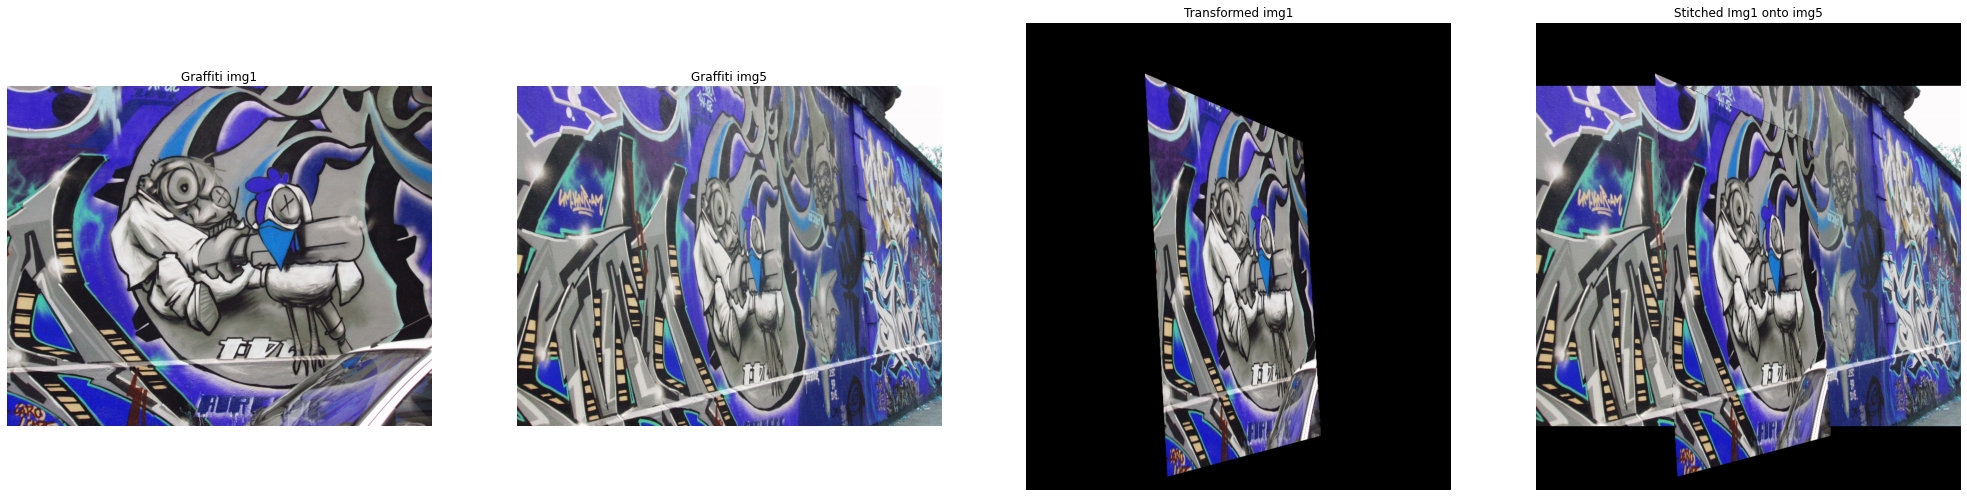